# Time-series Prediction using MLP & LSTM

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import numpy as np

## Datetime parser

In [8]:
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')

## Load dataset

In [9]:
dataset = pd.read_csv('/content/drive/My Drive/Dataset/daily-min-temperatures.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

dataset.head()

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

## Plot dataset

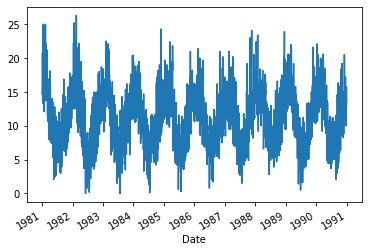

In [10]:
dataset.plot()
plt.show()

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

## Processing Time-series Data

In [12]:
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	return df

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [13]:
lag = 1

raw_values = dataset.values
diff_values = difference(raw_values, 1)

diff_values

0      -2.8
1       0.9
2      -4.2
3       1.2
4       0.0
       ... 
3644   -0.6
3645   -0.4
3646   -0.1
3647    2.2
3648   -2.7
Length: 3649, dtype: float64

In [14]:
supervised = timeseries_to_supervised(diff_values, lag)
supervised

,0,0
0,NaN,-2.8
1,-2.8,0.9
2,0.9,-4.2
3,-4.2,1.2
4,1.2,0.0
...,...,...
3644,1.7,-0.6
3645,-0.6,-0.4
3646,-0.4,-0.1
3647,-0.1,2.2


In [15]:
supervised_values = supervised.values[lag:,:]
supervised_values

array([[-2.8,  0.9],
       [ 0.9, -4.2],
       [-4.2,  1.2],
       ...,
       [-0.4, -0.1],
       [-0.1,  2.2],
       [ 2.2, -2.7]])

In [16]:
split_percentage = 0.75

train_size = int(split_percentage * len(supervised_values))

train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1)) # Range hasil scaling menjadi angka diantara -1 hingga 1
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [18]:
train_scaled

array([[-0.11607143,  0.21428571],
       [ 0.21428571, -0.24107143],
       [-0.24107143,  0.24107143],
       ...,
       [-0.16071429,  0.375     ],
       [ 0.375     ,  0.125     ],
       [ 0.125     , -0.16071429]])

# Baseline model

In [19]:
neurons = 1
epoch = 1000
batch_size = 32

feature_train, label_train = train_scaled[:, 0:-1], train_scaled[:, -1]
feature_test, label_test = test_scaled[:, 0:-1], test_scaled[:, -1]

model = Sequential()
model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 3ms/step - loss: 0.0722 - val_loss: 0.0603
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0565
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0560
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0560
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0560
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0560
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0560
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0560
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0560
Epoch 10/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0560

In [20]:
loss = model.evaluate(feature_test, label_test, verbose=2)

print("Test loss:", loss)

29/29 - 0s - loss: 0.0560
Test loss: 0.05596500635147095


In [21]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.grid(True)

In [22]:
history_dataframe = pd.DataFrame(history.history)
history_dataframe['epoch'] = history.epoch
history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
186,0.060668,0.055944,186
330,0.060689,0.055944,330
327,0.060709,0.055945,327
37,0.060653,0.055945,37
52,0.060672,0.055946,52
...,...,...,...
662,0.060682,0.056006,662
3,0.060696,0.056007,3
2,0.060908,0.056042,2
1,0.062512,0.056539,1


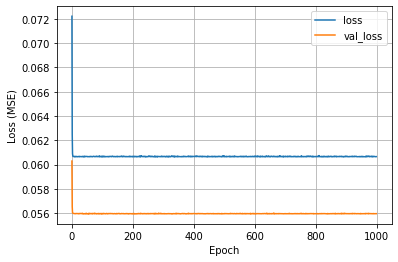

In [23]:
plot_loss(history) # epoch vs loss graph

# Deeper model

In [24]:
neurons = 1
epoch = 1000
batch_size = 32

deeper_model = Sequential()
deeper_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
deeper_model.add(Dense(5, activation='relu'))
deeper_model.add(Dense(1))
deeper_model.compile(loss='mean_squared_error', optimizer='adam')
deeper_model_history = deeper_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 3ms/step - loss: 0.0655 - val_loss: 0.0561
Epoch 2/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0606 - val_loss: 0.0549
Epoch 3/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0600 - val_loss: 0.0548
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0597 - val_loss: 0.0547
Epoch 5/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0547
Epoch 6/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0595 - val_loss: 0.0546
Epoch 7/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0595 - val_loss: 0.0546
Epoch 8/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.0546
Epoch 9/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.0546
Epoch 10/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0593 - val_loss: 0.0546

In [25]:
deeper_history_dataframe = pd.DataFrame(deeper_model_history.history)
deeper_history_dataframe['epoch'] = deeper_model_history.epoch
deeper_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
318,0.058991,0.054435,318
594,0.059003,0.054438,594
665,0.059040,0.054440,665
669,0.059043,0.054440,669
288,0.059023,0.054442,288
...,...,...,...
517,0.059015,0.054667,517
3,0.059714,0.054698,3
2,0.059957,0.054801,2
1,0.060591,0.054944,1


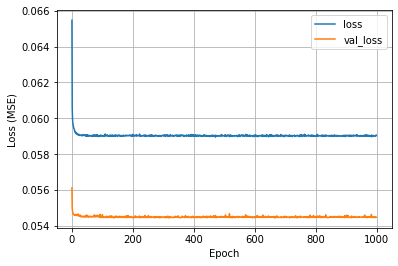

In [26]:
plot_loss(deeper_model_history) # epoch vs loss graph

# Wider model

In [27]:
neurons = 50
epoch = 1000
batch_size = 32

wider_model = Sequential()
wider_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
wider_model.add(Dense(1))
wider_model.compile(loss='mean_squared_error', optimizer='adam')
wider_model_history = wider_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0617 - val_loss: 0.0549
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0591 - val_loss: 0.0541
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0542
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0540
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0585 - val_loss: 0.0539
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0584 - val_loss: 0.0541
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0584 - val_loss: 0.0542
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0583 - val_loss: 0.0541
Epoch 9/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0540
Epoch 10/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0543

In [28]:
wider_history_dataframe = pd.DataFrame(wider_model_history.history)
wider_history_dataframe['epoch'] = wider_model_history.epoch
wider_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
56,0.057997,0.053731,56
39,0.058041,0.053732,39
59,0.058008,0.053742,59
57,0.057917,0.053743,57
96,0.057951,0.053750,96
...,...,...,...
259,0.057610,0.054626,259
41,0.058188,0.054640,41
952,0.057312,0.054733,952
28,0.058148,0.054774,28


# LSTM

In [29]:
from tensorflow.keras.layers import LSTM

epoch = 1000
batch_size = 32

# Reshape menjadi (jumlah sample, time steps, jumlah feature)
# Time steps: jumlah lag, gunakan default 1
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], 1, feature_train.shape[1]))
feature_test_reshaped = np.reshape(feature_test, (feature_test.shape[0], 1, feature_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_dim=feature_train.shape[1])) # 50 LSTM Block
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model_history = lstm_model.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test_reshaped, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 4ms/step - loss: 0.0660 - val_loss: 0.0554
Epoch 2/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.0543
Epoch 3/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0588 - val_loss: 0.0540
Epoch 4/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.0539
Epoch 5/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0540
Epoch 6/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0541
Epoch 7/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0540
Epoch 8/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0539
Epoch 9/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0583 - val_loss: 0.0539
Epoch 10/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0539

In [30]:
lstm_history_dataframe = pd.DataFrame(lstm_model_history.history)
lstm_history_dataframe['epoch'] = lstm_model_history.epoch
lstm_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
555,0.057817,0.053735,555
572,0.057831,0.053742,572
500,0.057859,0.053743,500
507,0.057954,0.053749,507
581,0.057790,0.053749,581
...,...,...,...
175,0.058172,0.054390,175
41,0.058035,0.054399,41
183,0.058213,0.054430,183
217,0.058058,0.054494,217


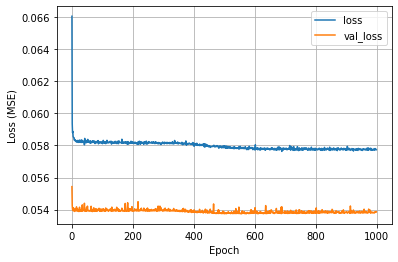

In [31]:
plot_loss(lstm_model_history)

BASELINE (loss : 0.060668, val_loss :	0.055944, epochs :	186)

DEEPER MODEL(loss : 0.058991, val_loss :	0.054435, epochs :	318)

WIDER MODEL(loss : 0.057997, val_loss :	0.053731, epochs :	56)

LSTM(loss : 0.057817, val_loss :	0.053735, epochs :	555)

Kesimpulan : nilai val_loss terendah ada pada model wider, tidak jauh berbeda dengan LSTM. Sehingga kedua model ini merupakan model terbaik.